In [1]:
import datasets
import os
from torch.utils.data import DataLoader, random_split
import torch
import torchvision
from transformers import ViTImageProcessor
from transformers import ViTForImageClassification
import matplotlib.pyplot as plt
import lightning
import numpy as np

/home/sarah/.pyenv/versions/3.10.6/envs/bunbetsu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-16 19:06:48.539984: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-16 19:06:51.041782: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k')
model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [3]:
image_mean = processor.image_mean
image_std = processor.image_std
size = processor.size["height"]

In [4]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

In [5]:
current_dir = os.getcwd()
data_set_img = torchvision.datasets.ImageFolder(root=current_dir + '/garbage/TRAIN', transform=_train_transforms)

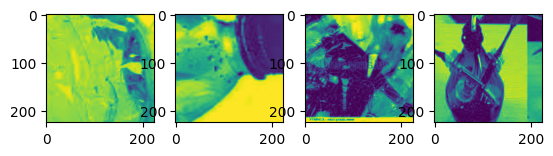

In [6]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)

image_one = data_set_img[0][0][0]
ax1.imshow(image_one)
ax2.imshow(data_set_img[1][0][0])
ax3.imshow(data_set_img[2][0][0])
ax4.imshow(data_set_img[3][0][0])

In [7]:
#See the data balance

In [8]:
len(data_set_img.samples)

41045

In [9]:
#Split into train. test. val

In [10]:
train_split, val_split, test_split = random_split(data_set_img, [0.8, 0.1, 0.1])

In [11]:
len(train_split.indices)

32837

In [12]:
id2label = {id:label for id, label in enumerate(data_set_img.classes)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'PET',
 1: 'books_and_paper',
 2: 'burnable',
 3: 'cans',
 4: 'cardboard',
 5: 'clothes',
 6: 'danger',
 7: 'glass_bin',
 8: 'metal',
 9: 'nonburn',
 10: 'plastic'}

In [13]:
id2label[data_set_img[0][1]]

'PET'

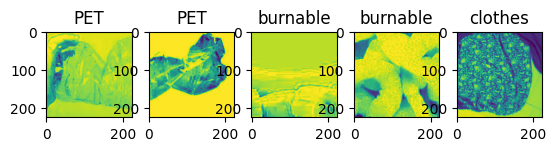

In [14]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5)

ax1.set_title(id2label[data_set_img[0][1]])
ax1.imshow(data_set_img[0][0][0])
ax2.set_title(id2label[data_set_img[1][1]])
ax2.imshow(data_set_img[1][0][0])
ax3.set_title(id2label[data_set_img[5000][1]])
ax3.imshow(data_set_img[5000][0][0])
ax4.set_title(id2label[data_set_img[10000][1]])
ax4.imshow(data_set_img[10000][0][0])
ax5.set_title(id2label[data_set_img[30000][1]])
ax5.imshow(data_set_img[30000][0][0])

In [15]:
#Split the dataset

In [16]:
data_set_img.classes

['PET',
 'books_and_paper',
 'burnable',
 'cans',
 'cardboard',
 'clothes',
 'danger',
 'glass_bin',
 'metal',
 'nonburn',
 'plastic']

In [17]:
def collate_iguess(examples):
    pixel_values = torch.stack([example[0] for example in examples])
    labels = torch.tensor([example[1] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [18]:
train_dataloader = DataLoader(train_split, shuffle=True, collate_fn=collate_iguess, batch_size=32, num_workers=7)
test_dataloader = DataLoader(test_split, shuffle=True, collate_fn=collate_iguess, batch_size=32, num_workers=7)
val_dataloader = DataLoader(val_split, shuffle=False, collate_fn=collate_iguess, batch_size=32, num_workers=7)

In [19]:
train_dataloader.__dict__

{'dataset': <torch.utils.data.dataset.Subset at 0x7f6b3de83e80>,
 'num_workers': 7,
 'prefetch_factor': 2,
 'pin_memory': False,
 'pin_memory_device': '',
 'timeout': 0,
 'worker_init_fn': None,
 '_DataLoader__multiprocessing_context': None,
 '_dataset_kind': 0,
 'batch_size': 32,
 'drop_last': False,
 'sampler': <torch.utils.data.sampler.RandomSampler at 0x7f6b2ff631f0>,
 'batch_sampler': <torch.utils.data.sampler.BatchSampler at 0x7f6b2ff61270>,
 'generator': None,
 'collate_fn': <function __main__.collate_iguess(examples)>,
 'persistent_workers': False,
 '_DataLoader__initialized': True,
 '_IterableDataset_len_called': None,
 '_iterator': None}

In [20]:
# for batch in train_dataloader:
#     images = batch["pixel_values"]
#     labels = batch["labels"]
#     print("Batch of images shape:", images.shape)
#     print("Batch of labels shape:", labels.shape)

In [21]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([32, 3, 224, 224])
labels torch.Size([32])


In [22]:
# batch["pixel_values"]

In [23]:
# Define the model

In [24]:
import pytorch_lightning as pl
from transformers import ViTForImageClassification, AdamW
import torch.nn as nn

class ViTLightningModule(pl.LightningModule):
    def __init__(self, num_labels=11):
        super(ViTLightningModule, self).__init__()
        self.vit = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                              num_labels=11,
                                                              id2label=id2label,
                                                              label2id=label2id)

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        return outputs.logits
        
    def common_step(self, batch, batch_idx):
        pixel_values = batch['pixel_values']
        labels = batch['labels']
        logits = self(pixel_values)

        criterion = nn.CrossEntropyLoss()
        loss = criterion(logits, labels)
        predictions = logits.argmax(-1)
        correct = (predictions == labels).sum().item()
        accuracy = correct/pixel_values.shape[0]

        return loss, accuracy
      
    def training_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        self.log("training_accuracy", accuracy)

        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss, on_epoch=True)
        self.log("validation_accuracy", accuracy, on_epoch=True)

        return loss

    def test_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     

        return loss

    def configure_optimizers(self):
        # We could make the optimizer more fancy by adding a scheduler and specifying which parameters do
        # not require weight_decay but just using AdamW out-of-the-box works fine
        return AdamW(self.parameters(), lr=5e-5)

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

    def test_dataloader(self):
        return test_dataloader

In [25]:
# Train model

In [26]:
# from tensorflow.keras.callbacks import TensorBoard

# # Start tensorboard.
# %load_ext tensorboard
# %tensorboard --logdir lightning_logs/

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

# for early stopping, see https://pytorch-lightning.readthedocs.io/en/1.0.0/early_stopping.html?highlight=early%20stopping
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    strict=False,
    verbose=False,
    mode='min'
)

model = ViTLightningModule()
trainer = Trainer(callbacks=[EarlyStopping(monitor='validation_loss')])
trainer.fit_loop.max_epochs=25
trainer.fit(model)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/sarah/.pyenv/versions/3.10.6/envs/bunbetsu/lib/python3.10/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name | Type                      | Params
---------------------------------------------------
0 | vit  | ViTForImageClassification | 85.8 M
---------------------------------------------------
85.8

Epoch 0:   0%|                                                                                 | 0/1027 [00:00<?, ?it/s]